In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams.update({'font.size': 16})
from matplotlib.backends.backend_pdf import PdfPages
import json
from argparse import Namespace

In [2]:
meta_file = "/data5/deepro/starrseq/data/meta_data/metadata.json"
all_lib_names = ["input", "control"]
store_dir = "/data5/deepro/starrseq/main_library/2_quality_control_lib/data/"

In [3]:
def read_and_extract_coverage(cov_bed):
    df = pd.read_csv(cov_bed, sep="\t", header=None)
    roi_depth = df.iloc[:, -4]
    return roi_depth

def create_args(meta_file, lib_name):
    with open(meta_file, "r") as f: 
        meta_dict = json.load(f)
        
    args = Namespace(
        # from metadata file
        library_prefix = meta_dict[lib_name]["prefix"],
        library_reps = meta_dict[lib_name]["replicates"],
        library_pair= meta_dict[lib_name]["read_pairs"],
        library_umi = meta_dict[lib_name]["umi"],
        library_suffix = meta_dict[lib_name]["suffix"],
        library_short = meta_dict[lib_name]["shortform"],
        reference_genome = meta_dict["genome"]["ref_fasta"],
        reference_genome_twobit = meta_dict["genome"]["ref_twobit"],
        genome_sizes = meta_dict["genome"]["chrom_sizes"],
        roi_file = meta_dict["roi"]["sorted"],
        roi_window_file = meta_dict["roi"]["window"],
    )

    return args

def get_depth_bed_filepaths(store_dir, lib_short, lib_prefix, lib_rep):
    return os.path.join(store_dir, "cov", lib_short, f"{lib_prefix}_{lib_rep}.bed")

def get_lib_depth_beds_filepaths(store_dir, lib_short, lib_prefix, lib_reps):
    depth_beds = [get_depth_bed_filepaths(store_dir, lib_short, lib_prefix, lib_rep) for lib_rep in lib_reps.split()]
    return depth_beds

In [4]:
lib_dfs = []

for lib_name in all_lib_names:
    lib_args = create_args(meta_file, lib_name)
    lib_beds = get_lib_depth_beds_filepaths(store_dir, lib_args.library_short, lib_args.library_prefix, lib_args.library_reps)
    lib_df = pd.concat(list(map(read_and_extract_coverage, lib_beds)), axis=1)
    lib_df.columns = [f"{lib_name.upper()} Rep {i}" for i in range(1, len(lib_beds)+1)] 
    lib_dfs.append(lib_df)

In [5]:
meta_df = pd.concat([df for df in lib_dfs], axis=1) 

# Fig S3-A

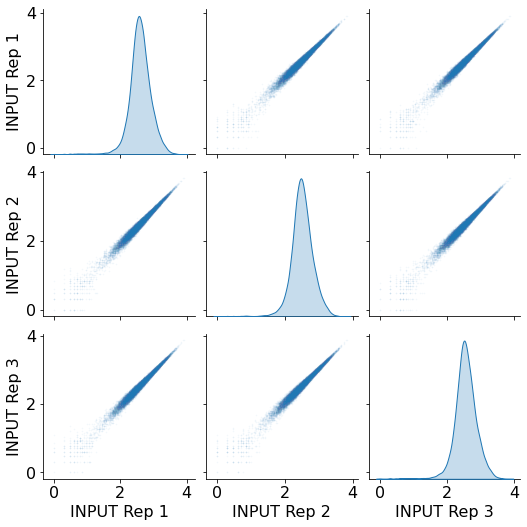

In [6]:
in_p = sns.pairplot(np.log10(lib_dfs[0].loc[(lib_dfs[0]>0).all(axis=1)]), diag_kind="kde", plot_kws={"s": 2.5, 'alpha': 0.05})
for a in in_p.fig.axes:
    if len(a.collections)==1:
        a.collections[0].set_rasterized(True)

# Fig S3-B

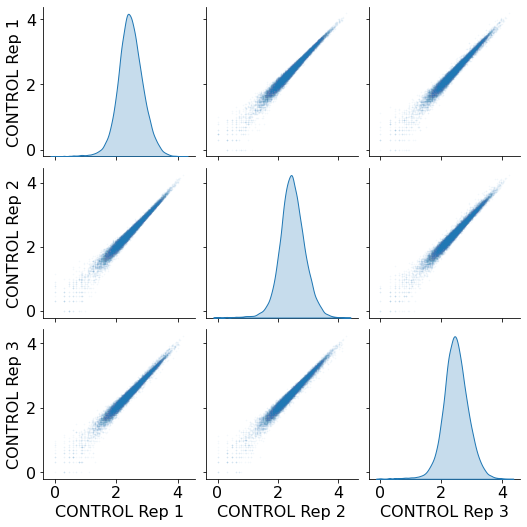

In [7]:
out_p = sns.pairplot(np.log10(lib_dfs[1].loc[(lib_dfs[1]>0).all(axis=1)]), diag_kind="kde", plot_kws={"s": 2.5, 'alpha': 0.05})
for a in out_p.fig.axes:
    if len(a.collections)==1:
        a.collections[0].set_rasterized(True)

In [8]:
stats_table_files = [
    "../data/in_house/table/IN/stats.csv",
    "../data/in_house/table/CC/stats.csv"
]

In [9]:
def get_lib_reads(lib_stats_file):
    df = pd.read_csv(lib_stats_file, header=None, skiprows=3, names=["read_type", "replicate", "read_num"])
    return df.loc[df.read_type=="filtered_reads_pair1"].read_num.values

all_library_reads = {
    ln: get_lib_reads(lsf) for ln, lsf in zip(all_lib_names, stats_table_files)
}

In [10]:
def get_rpm_norm_fc(in_df, lib_df, lib_name, in_name="input"):
    in_reads = all_library_reads[in_name]
    lib_reads = all_library_reads[lib_name]
    in_df_rpm = in_df.divide(in_reads, axis=1)*1e6
    lib_df_rpm = lib_df.divide(lib_reads, axis=1)*1e6
    in_df_rpm.columns = [i for i in range(in_df_rpm.shape[1])]
    lib_df_rpm.columns = [i for i in range(lib_df_rpm.shape[1])]
    lib_df_rpm_fc = lib_df_rpm.divide(in_df_rpm)
    lib_df_rpm_fc = lib_df_rpm_fc.replace([np.inf, -np.inf, np.nan], 0)
    return lib_df_rpm_fc

In [11]:
meta_libs = [meta_df.loc[:, [c for c in meta_df.columns if c.startswith(ln.upper())]] for ln in all_lib_names]

In [12]:
rpm_norm_fc_df = get_rpm_norm_fc(meta_libs[0], meta_libs[1], "control")

# Fig S3-C

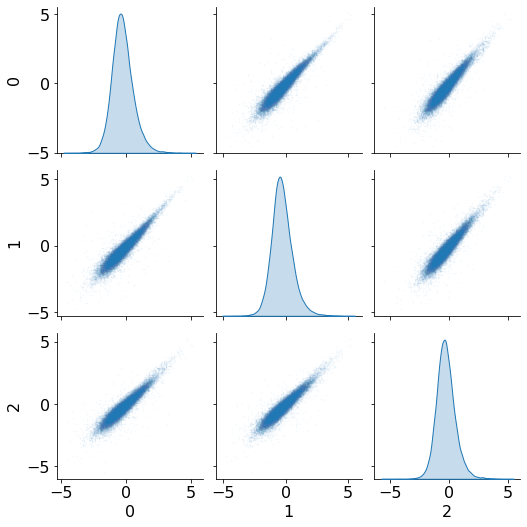

In [13]:
fc = sns.pairplot(np.log2(rpm_norm_fc_df.loc[(rpm_norm_fc_df>0).all(axis=1)]), diag_kind="kde", plot_kws={"s": 2.5, 'alpha': 0.05})
for a in fc.fig.axes:
    if len(a.collections)==1:
        a.collections[0].set_rasterized(True)